# Single stock analysis example in pyfolio

Here's a simple example where we produce a set of plots, called a tear sheet, for a stock.

## Import pyfolio

In [1]:
%matplotlib inline
import pyfolio as pf

## Fetch the daily returns for a stock

#### Import helper functions at the bottom of notebook first [helper-functions]

In [2]:
# Choose symbol and time horizon
symbol = 'BP'
start_date = '5/21/2012'
end_date = '8/22/2017'

In [12]:
stock_rets = symbol_pipeline(symbol, start=start_date, end=end_date)

## Fetch the Benchmark daily returns

In [13]:
# Choose symbol and time horizon
symbol = 'XOM'
start_date = '2012-5-12'
end_date = '2017-8-22'

In [14]:
benchmark_rets = symbol_pipeline(symbol, start=start_date, end=end_date)


## Create a full tear sheet for the single stock
This will show charts about returns and shock events.

Entire data start date: 2012-05-22
Entire data end date: 2017-08-21
In-sample months: 42
Out-of-sample months: 20


,All,In-sample,Out-of-sample
Annual return,2.0%,2.4%,1.0%
Cumulative returns,10.8%,8.9%,1.8%
Annual volatility,23.1%,21.6%,25.8%
Sharpe ratio,0.20,0.22,0.17
Calmar ratio,0.06,0.08,0.04
Stability,0.43,0.08,0.55
Max drawdown,-31.7%,-31.7%,-28.3%
Omega ratio,1.04,1.04,1.03
Sortino ratio,0.29,0.32,0.24
Skew,0.26,0.20,0.32


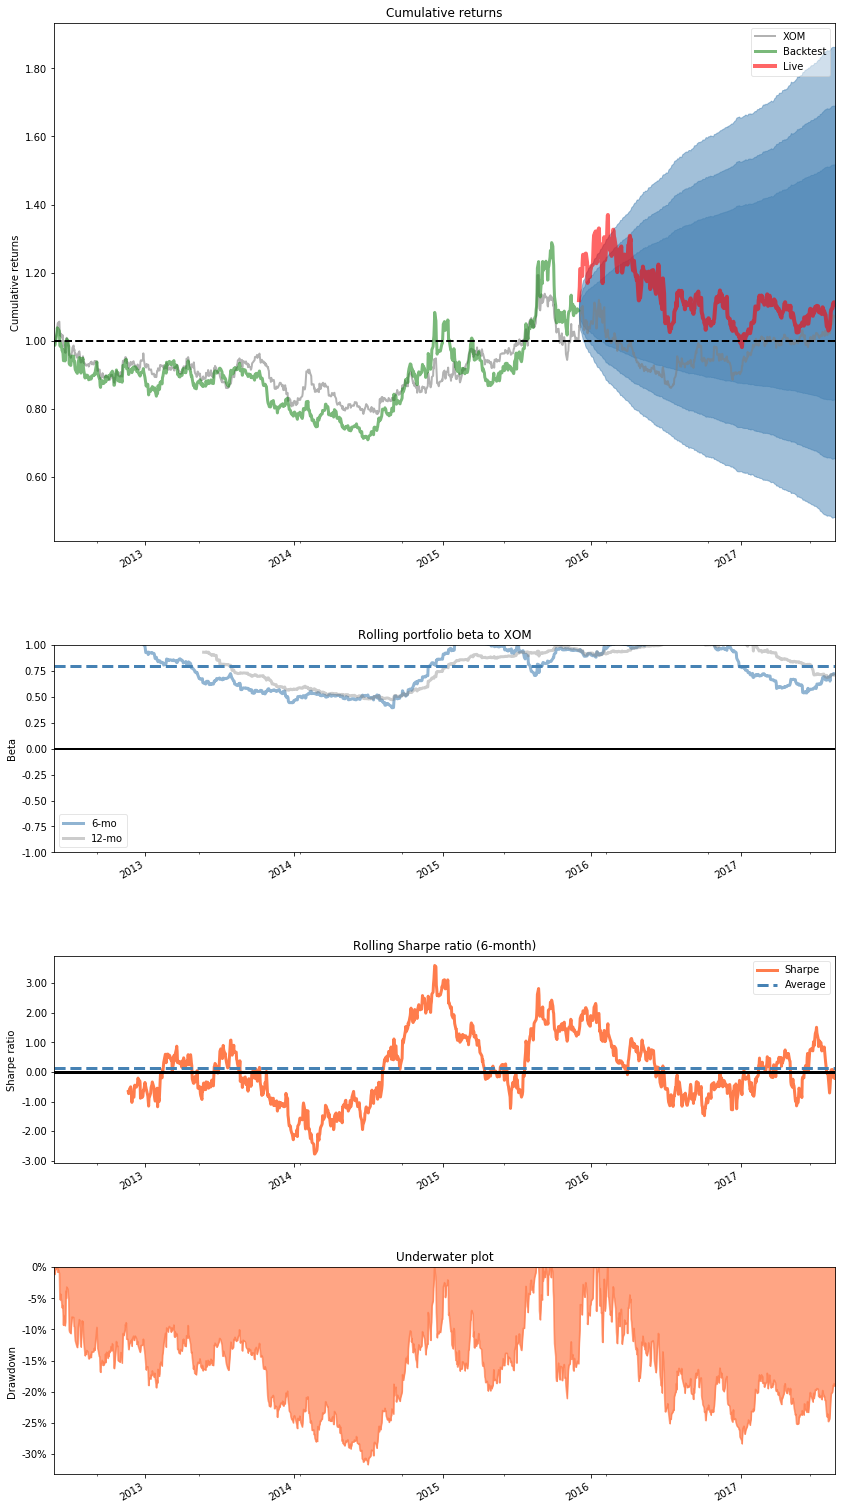

In [15]:
pf.create_simple_tear_sheet(stock_rets, benchmark_rets=benchmark_rets, live_start_date='2015-12-1')

## Individual plots

In [16]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
live_start_date='2015-12-1'

In [17]:
returns = stock_rets[stock_rets.index > benchmark_rets.index[0]]

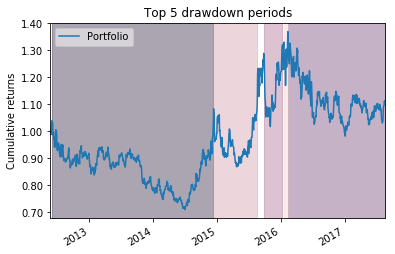

In [18]:
fig = plt.figure(facecolor='white')
ax = pf.plot_drawdown_periods(returns, top=5)

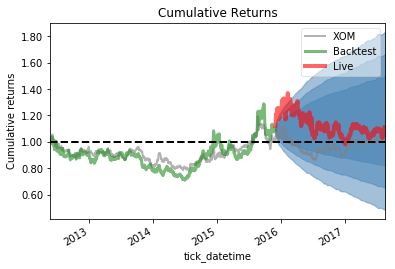

In [19]:
fig = plt.figure(facecolor='white')
ax = pf.plot_rolling_returns(returns,
                             factor_returns=benchmark_rets, 
                             live_start_date=live_start_date, 
                             cone_std=(1.0, 1.5, 2.0)).set_title('Cumulative Returns')

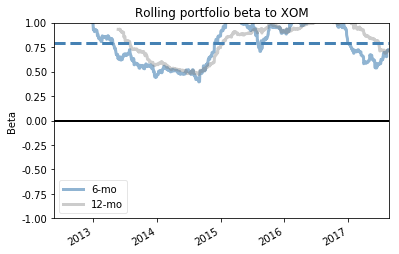

In [20]:
fig = plt.figure(facecolor='white')
ax = pf.plot_rolling_beta(returns, benchmark_rets)

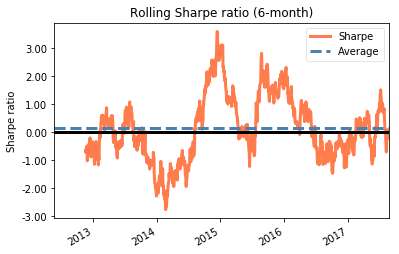

In [21]:
fig = plt.figure(facecolor='white')
ax = pf.plotting.plot_rolling_sharpe(returns)

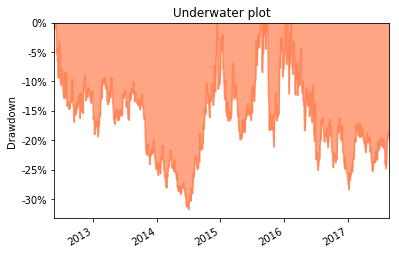

In [22]:
fig = plt.figure(facecolor='white')
ax = pf.plotting.plot_drawdown_underwater(returns)

## Functions to replace broken pyfolio APIs

In [23]:
# New functions to grab monthly open price data from yahoo
# Works as of April 2018
# Cleaning function for use with pyfolio

import pandas as pd
import datetime
import requests
def get_yahoo_finance_data(symbol, start=None, end=None, interval='1d'):
    end = pd.to_datetime(end) or datetime.datetime.utcnow()
    start = pd.to_datetime(start) or end - datetime.timedelta(days=24)
    url = 'https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?symbol={symbol}&period1={start}&period2={end}&interval={interval}&includePrePost=true&events=div%7Csplit%7Cearn&corsDomain=finance.yahoo.com'.format(
        symbol=symbol,
        start=start.strftime('%s'),
        end=end.strftime('%s'),
        interval=interval
    )
    resp = requests.get(url)
    resp.raise_for_status()
    
    rt = resp.json()
    
    return resp.json()

def get_correct_data_format(resp_json):
    symbol = resp_json['chart']['result'][0]['meta']['symbol']
    timestamps = resp_json['chart']['result'][0]['timestamp']
    open_price = resp_json['chart']['result'][0]['indicators']['quote'][0]['open']
    close_price = resp_json['chart']['result'][0]['indicators']['quote'][0]['close']
    
    ts = pd.DataFrame({'open' : pd.Series(open_price, index=pd.to_datetime(timestamps, unit='s')),
                       'close' : pd.Series(close_price, index=pd.to_datetime(timestamps, unit='s'))})
    ts.name = symbol
    ts.index = pd.to_datetime(ts.index, unit='s')
    
    return ts
    

# def get_symbol_returns_custom(ts):
#     rets = ts[['close']].pct_change().dropna()
#     rets.index = rets.index.to_datetime()
#     rets.index = rets.index.tz_localize("UTC")
#     rets.columns = [ts.name]
#     rets = pd.Series(rets[ts.name])
    
#     return rets


def get_symbol_returns_custom(ts, symbol):
    rets = ts[['close']]
    rets = rets.shift(-1)
    rets.iloc[-1]['close'] = ts.tail(1)['open']
    rets = rets.shift(1) / rets - 1
    rets = rets.dropna()
    rets['tick_datetime'] = pd.to_datetime(rets.index)   
    rets.set_index('tick_datetime',inplace=True)
    rets.index = rets.index.tz_localize("UTC")
    rets.columns = [symbol]
    rets = pd.Series(rets[symbol])
    return rets


def symbol_pipeline(symbol, start='5/21/2012', end='8/22/2017'):
    x = get_yahoo_finance_data(symbol, start, end, interval='1d')
    y = get_correct_data_format(x)
    z = get_symbol_returns_custom(y, symbol)
    
    return z



In [24]:
%%capture cap --no-stderr
pf.show_perf_stats(stock_rets, benchmark_rets, live_start_date='2015-12-1')

In [25]:
with open('output.txt', 'w') as out:
   out.write(cap.stdout)

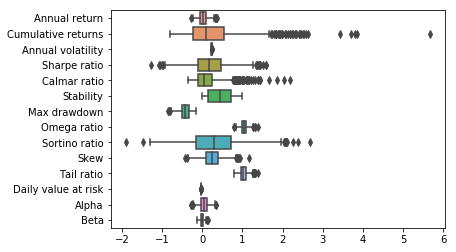

In [26]:
pf.plot_perf_stats(stock_rets, benchmark_rets)

In [29]:
show_perf_stats(returns, benchmark_rets, live_start_date=live_start_date).to_html

NameError: name 'timeseries' is not defined

In [28]:
def show_perf_stats(returns, factor_returns, positions=None,
                    transactions=None, turnover_denom='AGB',
                    live_start_date=None, bootstrap=False,
                    header_rows=None):
    """
    Prints some performance metrics of the strategy.
    - Shows amount of time the strategy has been run in backtest and
      out-of-sample (in live trading).
    - Shows Omega ratio, max drawdown, Calmar ratio, annual return,
      stability, Sharpe ratio, annual volatility, alpha, and beta.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame, optional
        Prices and amounts of executed trades. One row per trade.
        - See full explanation in tears.create_full_tear_sheet
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading, after
        its backtest period.
    bootstrap : boolean, optional
        Whether to perform bootstrap analysis for the performance
        metrics.
         - For more information, see timeseries.perf_stats_bootstrap
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the displayed table.
    """

    if bootstrap:
        perf_func = timeseries.perf_stats_bootstrap
    else:
        perf_func = timeseries.perf_stats

    perf_stats_all = perf_func(
        returns,
        factor_returns=factor_returns,
        positions=positions,
        transactions=transactions,
        turnover_denom=turnover_denom)

    date_rows = OrderedDict()
    if len(returns.index) > 0:
        date_rows['Start date'] = returns.index[0].strftime('%Y-%m-%d')
        date_rows['End date'] = returns.index[-1].strftime('%Y-%m-%d')

    if live_start_date is not None:
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)
        returns_is = returns[returns.index < live_start_date]
        returns_oos = returns[returns.index >= live_start_date]

        positions_is = None
        positions_oos = None
        transactions_is = None
        transactions_oos = None

        if positions is not None:
            positions_is = positions[positions.index < live_start_date]
            positions_oos = positions[positions.index >= live_start_date]
            if transactions is not None:
                transactions_is = transactions[(transactions.index <
                                                live_start_date)]
                transactions_oos = transactions[(transactions.index >
                                                 live_start_date)]

        perf_stats_is = perf_func(
            returns_is,
            factor_returns=factor_returns,
            positions=positions_is,
            transactions=transactions_is,
            turnover_denom=turnover_denom)

        perf_stats_oos = perf_func(
            returns_oos,
            factor_returns=factor_returns,
            positions=positions_oos,
            transactions=transactions_oos,
            turnover_denom=turnover_denom)
        if len(returns.index) > 0:
            date_rows['In-sample months'] = int(len(returns_is) /
                                                APPROX_BDAYS_PER_MONTH)
            date_rows['Out-of-sample months'] = int(len(returns_oos) /
                                                    APPROX_BDAYS_PER_MONTH)

        perf_stats = pd.concat(OrderedDict([
            ('In-sample', perf_stats_is),
            ('Out-of-sample', perf_stats_oos),
            ('All', perf_stats_all),
        ]), axis=1)
    else:
        if len(returns.index) > 0:
            date_rows['Total months'] = int(len(returns) /
                                            APPROX_BDAYS_PER_MONTH)
        perf_stats = pd.DataFrame(perf_stats_all, columns=['Backtest'])

    for column in perf_stats.columns:
        for stat, value in perf_stats[column].iteritems():
            if stat in STAT_FUNCS_PCT:
                perf_stats.loc[stat, column] = str(np.round(value * 100,
                                                            1)) + '%'
    if header_rows is None:
        header_rows = date_rows
    else:
        header_rows = OrderedDict(header_rows)
        header_rows.update(date_rows)

    utils.print_table(
        perf_stats,
        float_format='{0:.2f}'.format,
        header_rows=header_rows,
    )
